In [ ]:
from vnstock import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error



In [ ]:
df = stock_historical_data("ACB", "2015-01-01", "2024-07-31", "1D")
df

,time,open,high,low,close,volume,ticker
0,2015-01-05,2800,2800,2760,2790,55888,ACB
1,2015-01-06,2760,2820,2750,2820,89802,ACB
2,2015-01-07,2820,2910,2820,2860,232861,ACB
3,2015-01-08,2860,2870,2830,2870,14880,ACB
4,2015-01-09,2870,2970,2830,2890,693623,ACB
...,...,...,...,...,...,...,...
2383,2024-07-25,24150,24150,23800,24050,7155800,ACB
2384,2024-07-26,24100,24150,24000,24100,3447400,ACB
2385,2024-07-29,24300,24300,24050,24150,4102600,ACB
2386,2024-07-30,24000,24150,23950,24150,5489200,ACB


In [ ]:
# Đặt cột 'time' làm index
df.set_index('time', inplace=True)

# Chọn các cột cần thiết cho mô hình, loại bỏ cột 'ticker'
data = df[['open', 'high', 'low', 'close', 'volume']].values

# Chuẩn hóa dữ liệu về khoảng [0, 1] sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Xem qua dữ liệu đã chuẩn hóa
print(scaled_data[:5])


[[0.00179051 0.         0.00273349 0.         0.00147639]
 [0.         0.00088613 0.0022779  0.00134469 0.00244117]
 [0.00268577 0.00487373 0.00546697 0.00313761 0.00651089]
 [0.00447628 0.00310146 0.00592255 0.00358584 0.0003098 ]
 [0.0049239  0.00753212 0.00592255 0.00448229 0.01961859]]


In [ ]:
# Xác định lookback period (số ngày sử dụng để dự đoán)
lookback = 60

# Tạo X và y từ dữ liệu chuẩn hóa, y sẽ là cột 'close'
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])  # Sử dụng toàn bộ dữ liệu của 5 cột
    y.append(scaled_data[i, 3])  # Dự đoán giá đóng cửa (close)

# Chuyển đổi X và y sang dạng numpy arrays
X, y = np.array(X), np.array(y)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (2328, 60, 5)
Shape of y: (2328,)


In [ ]:
# Reshape X thành định dạng 3D (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [ ]:
# Chuyển đổi chỉ số thành DatetimeIndex nếu chưa phải
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

train_start = '2015-01-01'
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-07-31'

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_indices = (df.index >= train_start) & (df.index <= train_end)
test_indices = (df.index >= test_start) & (df.index <= test_end)

X_train = X[train_indices[lookback:]]
y_train = y[train_indices[lookback:]]
X_test = X[test_indices[lookback:]]
y_test = y[test_indices[lookback:]]

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set: X_train: (2185, 60, 5), y_train: (2185,)
Test set: X_test: (143, 60, 5), y_test: (143,)


In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Lưu lịch sử loss để vẽ biểu đồ
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/20
69/69 [==============================] - 6s 46ms/step - loss: 0.0131 - val_loss: 4.6468e-04
Epoch 2/20
69/69 [==============================] - 2s 33ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 3/20
69/69 [==============================] - 2s 35ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/20
69/69 [==============================] - 3s 45ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/20
69/69 [==============================] - 3s 39ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/20
69/69 [==============================] - 3s 38ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 7/20
69/69 [==============================] - 3s 42ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/20
69/69 [==============================] - 3s 42ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/20
69/69 [==============================] - 3s 43ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/20
69/69 [==============================] - 3s 41ms/step - loss: 0.0013 - val_loss: 6.2763e-04
E

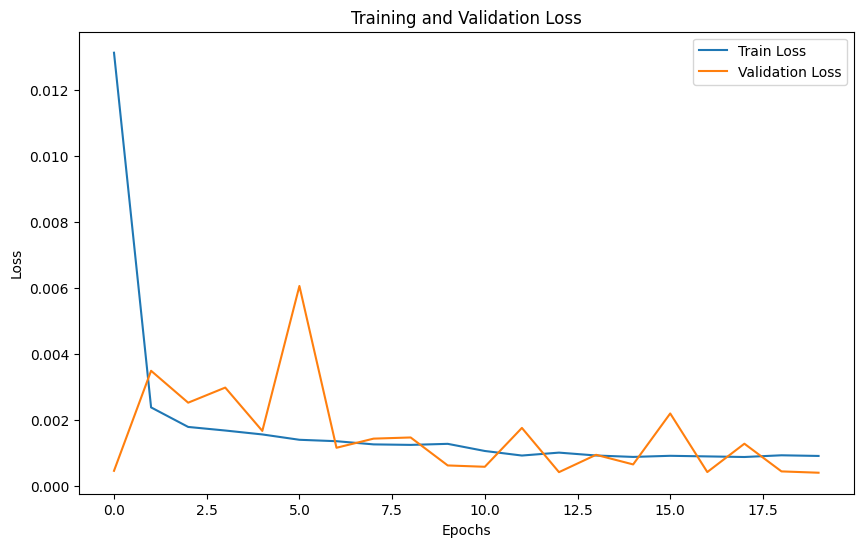

5/5 [==============================] - 2s 17ms/step


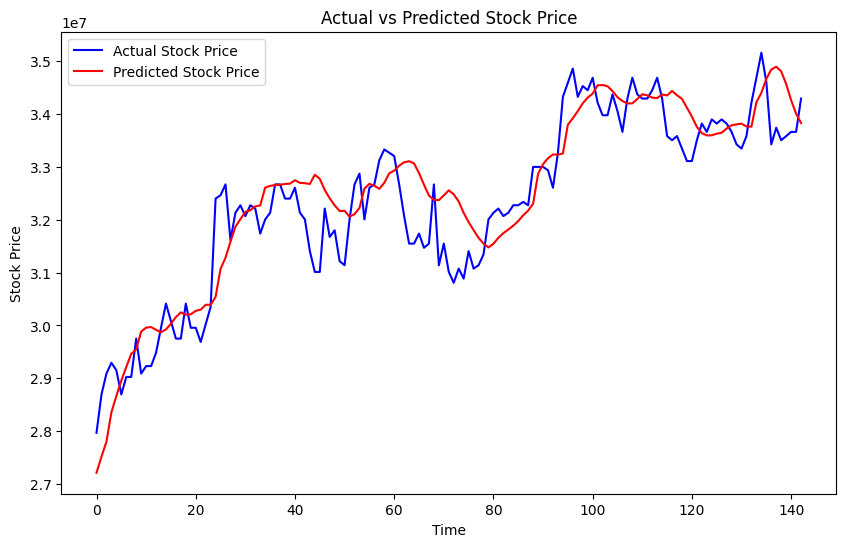

In [ ]:
# Vẽ biểu đồ loss qua các epochs
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Dự đoán trên tập kiểm tra
predictions = model.predict(X_test)

# Chuyển đổi dữ liệu dự đoán về dạng giá trị gốc
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], data.shape[1] - 1)), predictions), axis=1))[:, -1]
y_test_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Vẽ biểu đồ so sánh giá trị dự đoán và giá trị thực tế
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()


In [ ]:
# Tính các chỉ số MAE, MSE, RMSE, MAPE
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

r_squared = r2_score(y_test_actual, predictions)
print(f'R-squared: {r_squared}')

Mean Absolute Error (MAE): 554292.9203606214
Mean Squared Error (MSE): 502925104473.00885
Root Mean Squared Error (RMSE): 709172.126125251
Mean Absolute Percentage Error (MAPE): 0.017347931708151104
R-squared: 0.8128838318002136
